## Deep Network Tutorial

In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda
import torchvision.models as models
from torch import nn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os

### Initialize a Tensor

In [2]:
# directly from data
data = [[1, 2], [3, 4]]
x_data = torch.tensor(data)

# from np arrays
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

# from another tensor
x_ones = torch.ones_like(x_data)

x_rand = torch.rand_like(x_data, dtype = torch.float)

In [3]:
training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

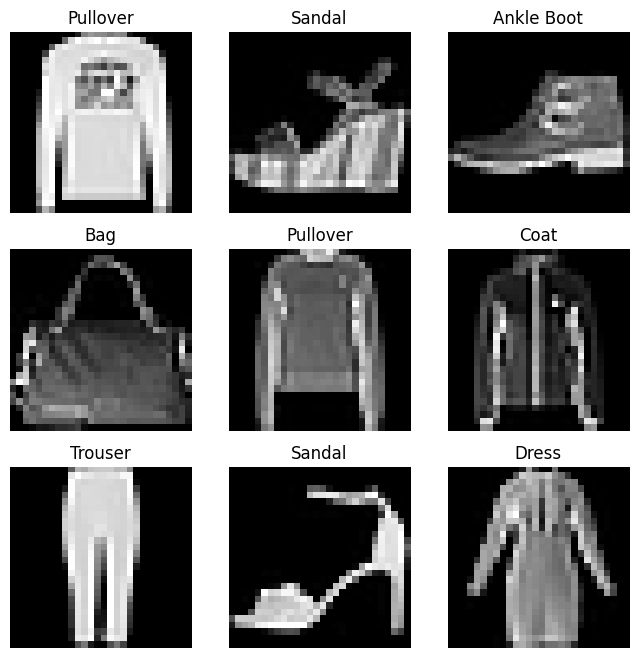

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

### Custom Dataset Class

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, annotation_file, img_dir, transform = None, target_transform = None):
        self.image_labels = pd.read_csv(annotation_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.image_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### Load Data Using DataLoader

In [6]:
train_dataloader = DataLoader(training_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)

### Display Image and Label

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
Label: 6


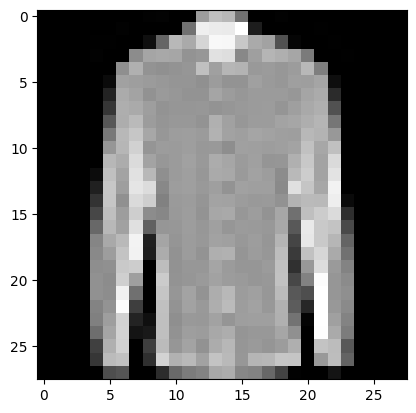

In [7]:
# extract a batch of data
train_features, train_labels = next(iter(train_dataloader))

# display info
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')

# get first image
img = train_features[1].squeeze()
label = train_labels[1]
plt.imshow(img, cmap = "gray")

print(f'Label: {label}')


### Load Data and Perfrom Tranforms: Normalization and OneHotEncoding

In [8]:
ds = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform = Lambda(lambda y: torch.zeros(10, dtype = torch.float).scatter_(0, torch.tensor(y), value = 1))
)

#### Build Neural Network

In [9]:
device = ( 
    "cuda" 
    if torch.cuda.is_available() 
    else "mps"
    if torch.backends.mps.is_available() 
    else "cpu"
)
print(f'Using {device} device')

Using mps device


#### Define NN Class ~ Subclass of ```nn.Module```

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

### Create Instance of NeuralNetwork

In [11]:
model = NeuralNetwork().to(device)

print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [12]:
X = torch.rand(1, 28, 28, device = device)
logits = model(X)
pred_prob = nn.Softmax(dim = 1)(logits)
y_pred = pred_prob.argmax(1)

print(f"Predicted Class: {y_pred}")

Predicted Class: tensor([7], device='mps:0')


### BREAKDOWN: Model Layers

In [13]:
# get a minibatch of 3 random images
input_image = torch.rand(3, 28, 28)
print(input_image.size())

torch.Size([3, 28, 28])


### nn.Flatten()

This will convert each 2D 28x28 image into a contiguous array of 784 pixel values

In [14]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


### nn.Linear

The ```linear layer``` is a module that applies a linear transformation on the input using its stored weights and biases.

In [15]:
layer1 = nn.Linear(in_features = 28*28, out_features = 20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


### nn.ReLU

Non-linear activations are what create the complex mappings between the model’s inputs and outputs. They are applied after linear transformations to introduce nonlinearity, helping neural networks learn a wide variety of phenomena.

In this model, we use nn.ReLU between our linear layers, but there’s other activations to introduce non-linearity in your model.

In [16]:
print(f'Before ReLU: {hidden1}\n\n')
hidden1 = nn.ReLU()(hidden1)
print(f'After ReLU: {hidden1}')

Before ReLU: tensor([[ 0.0182,  0.1779,  0.3254, -0.1002, -0.6530, -0.2750, -0.0163, -0.2407,
          0.2511, -0.0333, -0.2327,  0.3432,  0.2934,  0.3007,  0.1545,  0.1837,
          0.4180,  0.1724,  0.0187,  0.2209],
        [ 0.3531,  0.1686,  0.3602, -0.0394, -0.7638, -0.0104, -0.0436, -0.1918,
          0.2309, -0.0613, -0.2464,  0.3530,  0.3049,  0.1642,  0.5247,  0.8261,
          0.0305, -0.2443,  0.2084, -0.1337],
        [ 0.2834,  0.3871, -0.1093, -0.1325, -0.5876, -0.2543,  0.0774, -0.3674,
          0.0228, -0.2016, -0.1263,  0.4475,  0.0431,  0.1671,  0.0711,  0.6847,
          0.1460, -0.0768,  0.2495,  0.1430]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0182, 0.1779, 0.3254, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2511,
         0.0000, 0.0000, 0.3432, 0.2934, 0.3007, 0.1545, 0.1837, 0.4180, 0.1724,
         0.0187, 0.2209],
        [0.3531, 0.1686, 0.3602, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2309,
         0.0000, 0.0000, 0.3530, 0.3049, 0.1642, 0.52

### nn.Sequential

```nn.Sequential``` is an ordered container of modules. The data is passed through all the modules in the same order as defined. You can use sequential containers to put together a quick network like seq_modules.

In [17]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)

input_image = torch.rand(3, 28, 28)
logits = seq_modules(input_image)

### nn.Softmax

The last linear layer of the neural network returns logits - raw values in [-infty, infty] - which are passed to the nn.Softmax module. The logits are scaled to values [0, 1] representing the model’s predicted probabilities for each class. dim parameter indicates the dimension along which the values must sum to 1.

In [18]:
softmax = nn.Softmax(dim = 1)
pred_prob = softmax(logits)

### Model Parameters

Many layers inside a neural network are parameterized, i.e. have associated weights and biases that are optimized during training. Subclassing ```nn.Module``` automatically tracks all fields defined inside your model object, and makes all parameters accessible using your model’s ```parameters()``` or ```named_parameters()``` methods.

In this example, we iterate over each parameter, and print its size and a preview of its values.

In [19]:
print(f'Model Structure: {model}\n\n')

for name, param in model.named_parameters():
    print(f'Layer: {name} | Size: {param.size()} | Values: {param[:2]} \n')

Model Structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values: tensor([[-0.0130,  0.0330, -0.0034,  ...,  0.0047, -0.0113,  0.0271],
        [-0.0350,  0.0279, -0.0283,  ..., -0.0087, -0.0098,  0.0125]],
       device='mps:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values: tensor([-0.0277, -0.0199], device='mps:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values: tensor([[ 0.0205, -0.0073,  0.0258,  ..., -0.0124,  0.0273, -0.0092],
        [ 0.0205,  0.0221,  0.0260,  ..., -0.0080,  0.0071,  0.0080]],
       device='mps:0', grad_fn=<SliceBac

## Build Model

In [20]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

### Define Hyperparameters to Train Model

We define the following hyperparameters for training:

* ```Number of Epochs``` - the number times to iterate over the dataset

* ```Batch Size``` - the number of data samples propagated through the network before the parameters are updated

* ```Learning Rate``` - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

In [21]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

### Optimization Loop

Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each iteration of the optimization loop is called an ```epoch```.  

Each ```epoch``` consists of two main parts:

* **The Train Loop** - iterate over the training dataset and try to converge optimal parameters.
* **The Validation/Test Loop - iterate over the test dataset to check if model performance is improving

### Loss Function  

When presented with some training data, our untrained network is likely not to give the correct answer. ```Loss function``` measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training. To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include ```nn.MSELoss``` (Mean Square Error) for regression tasks, and ```nn.NLLLoss``` (Negative Log Likelihood) for classification. ```nn.CrossEntropyLoss``` combines ```nn.LogSoftmax``` and ```nn.NLLLoss```.

We pass our model’s output logits to ```nn.CrossEntropyLoss```, which will normalize the logits and compute the prediction error.

In [22]:
# initialize the loss function
loss_fn = nn.CrossEntropyLoss()

### Optimizer

Optimization is the process of adjusting model parameters to reduce model error in each training step. **Optimization algorithms** define how this process is performed (in this example we use Stochastic Gradient Descent). All optimization logic is encapsulated in the optimizer object. Here, we use the SGD optimizer; additionally, there are many **different optimizers** available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

We initialize the optimizer by registering the model’s parameters that need to be trained, and passing in the learning rate hyperparameter.

In [23]:
# define opitimizer
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

## Full Implementation

In [24]:
def train_loop(dataloader, model, loss_fn, optimizer):

    # get the size
    size = len(dataloader.dataset)

    # set model to training mode
    model.train()

    # iterate over batches
    for batch, (X, y) in enumerate(dataloader):

        # compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f'Loss: {loss:>7f} [{current:>5f}/{size:>5d}]')

def test_loop(dataloader, model, loss_fn):

    # get the size
    size = len(dataloader.dataset)

    # set to evaluate mode
    model.eval()
    num_batches = len(dataloader)

    test_loss, correct = 0, 0

    # turn of gradients for efficiency
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size

        print(f"Test Error: \n \
              Accuracy : {(100 * correct):>0.1f}% \n \
              Average Loss: {test_loss:>8f}\n")

We initialize the loss function and optimizer, and pass it to ```train_loop``` and ```test_loop```. Feel free to increase the number of epochs to track the model’s improving performance.

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

epochs = 25
for t in range(epochs):
    print(f'Epoch {t + 1} \n ---------------------------------------')
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!!")

Epoch 1 
 ---------------------------------------
Loss: 2.308484 [64.000000/60000]
Loss: 2.293152 [6464.000000/60000]
Loss: 2.284137 [12864.000000/60000]
Loss: 2.273996 [19264.000000/60000]
Loss: 2.252030 [25664.000000/60000]
Loss: 2.232810 [32064.000000/60000]
Loss: 2.235487 [38464.000000/60000]
Loss: 2.207793 [44864.000000/60000]
Loss: 2.201004 [51264.000000/60000]
Loss: 2.163967 [57664.000000/60000]
Test Error: 
               Accuracy : 44.1% 
               Average Loss: 2.162268

Epoch 2 
 ---------------------------------------
Loss: 2.173993 [64.000000/60000]
Loss: 2.162464 [6464.000000/60000]
Loss: 2.112946 [12864.000000/60000]
Loss: 2.120260 [19264.000000/60000]
Loss: 2.073972 [25664.000000/60000]
Loss: 2.021379 [32064.000000/60000]
Loss: 2.046650 [38464.000000/60000]
Loss: 1.974524 [44864.000000/60000]
Loss: 1.972120 [51264.000000/60000]
Loss: 1.896635 [57664.000000/60000]
Test Error: 
               Accuracy : 56.7% 
               Average Loss: 1.897554

Epoch 3 
 --------

In [26]:
# this is just to see the last score
train_loop(train_dataloader, model, loss_fn, optimizer)
test_loop(test_dataloader, model, loss_fn)

Loss: 0.492874 [64.000000/60000]
Loss: 0.606214 [6464.000000/60000]
Loss: 0.403346 [12864.000000/60000]
Loss: 0.647542 [19264.000000/60000]
Loss: 0.567600 [25664.000000/60000]
Loss: 0.567376 [32064.000000/60000]
Loss: 0.594977 [38464.000000/60000]
Loss: 0.673701 [44864.000000/60000]
Loss: 0.644218 [51264.000000/60000]
Loss: 0.568103 [57664.000000/60000]
Test Error: 
               Accuracy : 80.3% 
               Average Loss: 0.570280



### Save and Load Model

In [27]:
# save model
torch.save(model.state_dict(), "tut_model.pth")

To load model weights, you need to create an instance of the same model first, and then load the parameters using ```load_state_dict()``` method.

In [29]:
# load model
model = NeuralNetwork()
model.load_state_dict(torch.load('model.pth'))
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)